# EE P595 Homework 1: Twitter Spam Detection
### You can discuss on Slack, but you should submit your own code and answers

Welcome to the first homework of EE P595! Here we will apply the ML pipline introduced in the second lab to **Twitter spam message detection problems**. In the past few years, social medias like Twitter has become the target of spam posting. Automatic spam posts can not only affect user experience, but they can also spread misinformation and subtly affect public opinions.

In this homework, we will work on a mini Twitter message dataset extracted from the CRESCI-2017 dataset. This dataset contains 50000 Twitter messages, half of which are sent by real Twitter users and half of which generated by spam bots. Your task is to train classifiers that can tell these two kinds of messages apart. This time, you'll go deeper and try multiple feature extractors and classifiers. Like the labs, you will need to fill out blanks in code cells. You are also going to answer a few questions and **optionally** work on improvements to existing pipeline completely on your own.

## Feature Extraction

We will begin our ML pipeline with feature extraction in this homework, as the dataset is good enough and does not need any special pre-processing. As usual, we will load the dataset into memory, extract samples features into vectors and split the dataset into training and test sets.

In [9]:
import pandas as pd

## [ TODO ]
# 1) Load all data from `twitter-mini.csv` into variable `data`
# 2) Preview first few samples
data=pd.read_csv('twitter-mini.csv')
data.head()


,text,label
0,@baydiangirl it definitely moved some church f...,0
1,@suebob Looks like #TXlege made up new rules f...,0
2,RT @saleemchat: #WJChat #A1B 5 yrs: People ski...,0
3,@SajidaBalouch Huhhhhh,0
4,@Dukester_94 im the lad of all bibles,0


In lab 2 we have learned how to use the `CountVectorizer` feature extractor, which counts the occurance of each token (letter here) in a sample (Twitter message text here). This time, we will also try `TfidfVectorizer` and see which feature extractor performs better. Here we will introduce the algorithm it implemented, **TF-IDF**:

> **TF-IDF** is the abbreviation for **term frequency–inverse document frequency**, and is defined as the product of the two frequency. The most classical version of TF-IDF is:
>
> $$
tf-idf(t) = tf(t, d) \cdot idf(t, D) = \frac{f_{t,d}}{|d|} \log \frac{|D|}{|D_t|}
$$
>
> Where $t$ is the term, $D$ is the collection of all documents, $d$ is one of the document that contains $t$ and $D_t$ is the subset of documents that contains term $t$. The advantage of TF-IDF is that frequent and useless words, such as "the", "a" and "an" will receive lower weight, since they appear in almost all documents. On the other hand, unique yet frequent (in any $d \in D_t$) words will get higher weight. Research has shown that TF-IDF is easy to implement and performs relatively well.

Before we run these feature extractors on our dataset, we need to convert each message into a sequence of terms. Since Twitter messages often contain emojis, abbreviations, hashtags and other composition of characters, we can't use the word-level analyzer as we have done in lab 2. Instead, we will generate **character N-grams** from these messages.

> A **character N-gram** consists of N consecutive characters. Here we show all character 1, 2, 3 and 4-grams for word "cold":
> 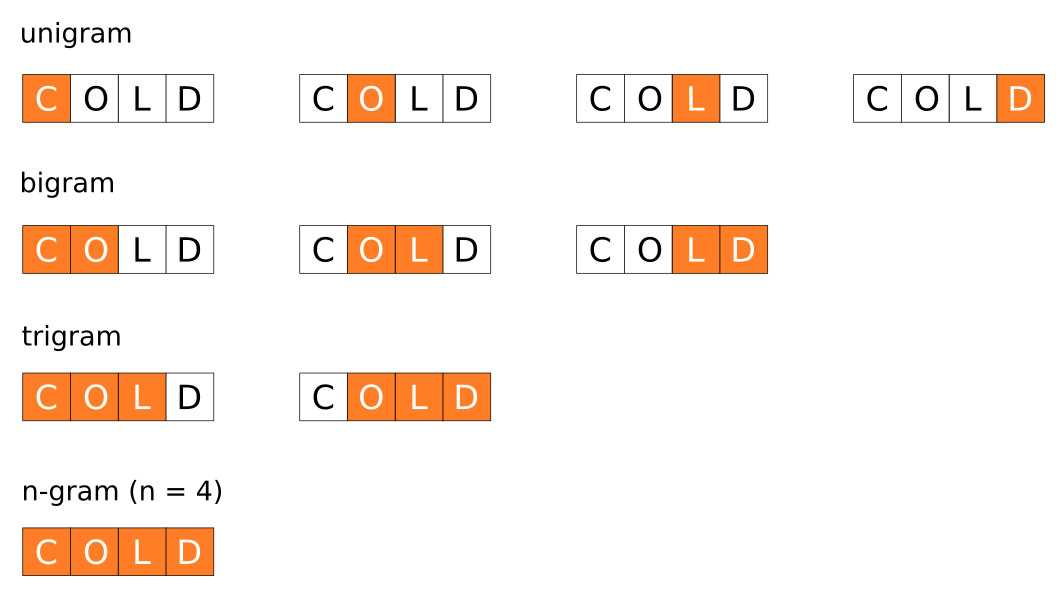

Both `CountVectorizer` and `TfidfVectorizer` provide support for character N-grams. Refer to `sklearn`'s documents to build a character N-gram analyzer.

In [10]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import scale

## [ TODO ]
# 1) Extract features of all messages into `feat1` with `CountVectorizer` using CHARACTER trigrams
# 2) Repeat with `TfidfVectorizer` and name generated features `feat2`
print("Extracting features with `CountVectorizer`...")
c=CountVectorizer()
feat1=c.fit_transform(data['text'])


print("Extracting features with `TfidfVectorizer`...")
t=TfidfVectorizer()
feat2=t.fit_transform(data['text'])

print("Completed.")


Extracting features with `CountVectorizer`...
Extracting features with `TfidfVectorizer`...
Completed.


We will also try combining two kinds of feature generated above into a single feature. We will use `scipy.sparse.hstack` to concatenate corresonding features for each sample. Remember, concatenated features matrix should have same amount of samples as `feat1` and `feat2`.

In [17]:
from scipy.sparse import hstack

## [ TODO ]
# Concatenate token count features and TF-IDF features on the feature dimension,
# name the combined feature matrix `feat_comb`.
feat_comb=hstack((feat1,feat2))



Finally, let's take a look at the labels. In our dataset, 0 represents messages from real Twitter users and 1 represents spam messages.

In [23]:
y = data["label"].values


(50000, 171010)

## Training

As usual, we will start by doing a 80% / 20% training-test split. Like lab 2, we suggest you to **use the same random seed for all splits** for comparable and reproducible results.

In [25]:
from scipy.sparse import hstack
from sklearn.model_selection import train_test_split

## [ TODO ]
# 1) Split token count features into 80/20 training and test sets
# 2) Split TF-IDF features into 80/20 training and test sets
# 3) Split combined features into 80/20 training and test sets

# Token count features
print("Spliting token count features...")
feat1_train, _, y1_train, _ = train_test_split(feat1,y,test_size=0.2)

# TF-IDF features
print("Spliting TF-IDF features...")
feat2_train, _, y2_train, _ = train_test_split(feat2,y,test_size=0.2)

# Combined features
print("Spliting combined features...")
feat_comb_train, _, y_comb_train, _ = train_test_split(feat_comb,y,test_size=0.2)

print("Completed.")

Spliting token count features...
Spliting TF-IDF features...
Spliting combined features...
Completed.


We are now ready to train binary classifiers for spam messages detection. Apart from `LogisticRegression` classifier you have seen and used during lab 2, we will try a few more classifiers:

* `RidgeClassifier`: This classifier is based on ridge regression algorithm, which is a variant of linear regression with L2 normalization. During training, we minimize the following ridge loss:

$$
l_{ridge} = ||\mathbf{y} - \mathbf{X} \mathbf{w}||_2^2 + \beta ||\mathbf{w}||_2^2
$$

where $y$ is a vector derived from labels, $\mathbf{X}$ is a matrix container a number of feature vectors, $\beta$ is regularization factor and $\mathbf{w}$ is a trainable weight vector. We have assumed that $\mathbf{X}$ here is demeaned (subtracted by the mean of original $\mathbf{X}$, denoted as $\overline{\mathbf{X}}$) and omit the bias term $\mathbf{b}$. In binary classification, we map the true label to $y = 1$ and false label to $y = -1$. The classification results for new samples are then determined by:

$$
\mathbf{y}_{pred} = sign(\mathbf{X} \mathbf{w})
$$

  By default, `RidgeClassifier` sets $\beta = 1$.

* `LinearSVC`: This classifier is based on linear SVM, which is a popular algorithm for binary classification. The linear SVM algorithm treats the feature vector of each sample as a point in the linear space, and tries to find a hyperplane that separates points of the two classes as good as possible. This is done by minimizing the sum of distances from each point to the hyperplane. In practice, we will optimize squared hinge loss with regularization for linear SVM rather than just the distances, as sample features may not be linear separable:

$$
l_{hinge} = \max(0, y(1 - \mathbf{x}^T \mathbf{w}))^2 + \beta ||\mathbf{w}||_2^2
$$

Similarly, the classification result is determined by:

$$
y_{pred} = sign(1 - \mathbf{x}^T \mathbf{w})
$$

We have three kinds of features (token count, TF-IDF and combined) and three kinds of classifiers. Here we will only try three combinations and compare their performance:

* `RidgeClassifier` on token count features
* `LogisticRegression` on TF-IDF features
  - Try increasing number of iterations if warning of non-convergence pops up
* `LinearSVC` on combined features
  - For linear SVM, you can ignore the non-convergence warning as it does not affect performance

In [26]:
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC

## [ TODO ]
# 1) Train a `RidgeClassifier` called `model1` on token count training set
# 2) Train a `LogisticRegression` classifier called `model2` on TF-IDF training set
# 3) Train a `LinearSVC` classifier called `model_comb` on combined features training set
print("Training ridge regression classifier on token count training set...")
model1=RidgeClassifier()
model1.fit(feat1_train,y1_train)

print("Training logistic regression classifier on TF-IDF training set...")
model2=LogisticRegression()
model2.fit(feat2_train,y2_train)

print("Training SVM classifier on combined features training set...")
model_comb=LinearSVC()
model_comb.fit(feat_comb_train,y_comb_train)

print("Completed.")

Training ridge regression classifier on token count training set...
Training logistic regression classifier on TF-IDF training set...
Training SVM classifier on combined features training set...
Completed.


## Evaluation

Finally, it's time to evaluate our models. You probably noticed that we have repeated similar code for different feature extraction and classification models. To avoid that, we will use `for` loops to make evaluation simpler:

In [27]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

features = [("Token count", feat1), ("TF-IDF", feat2), ("Combined", feat_comb)]
models = [("Ridge", model1), ("Logistic", model2), ("SVM", model_comb)]

## [ TODO ]
# Complete missing code in the loop body
for i, ((feat_name, feat), (model_name, model)) in enumerate(zip(features, models)):
    # Begin of metrics for combination
    print("====================")
    print(f"{i+1}. {model_name} on {feat_name}:\n")
    # 1) Split features into training and test set
    # (Note: you should use the same random number seed as the one in the training-test split above)
    feat_train, feat_test, y_train, y_test = train_test_split(feat,y,test_size=0.2,random_state=0)
    
    # 2) Predict labels for training data
    pred_train =model.predict(feat_train)

    # 3) Print metrics for training set (precision, recall and F1 metrics)
    print("Training metrics:", classification_report(y_train,pred_train))
    # Confusion matrix
    print("Training confusion matrix:\n", confusion_matrix(y_train,pred_train), "\n")
    # Accuracy
    print("Train accuracy:", accuracy_score(y_train,pred_train), "\n")

    # 4) Predict labels for test data
    pred_test = model.predict(feat_test)

    # 5) Print metrics for test set (precision, recall and F1 metrics)
    print("Test metrics:", classification_report(y_test,pred_test))
    # Confusion matrix
    print("Test Confusion Matrix:\n", confusion_matrix(y_test,pred_test), "\n")
    # Accuracy
    print("Test Accuracy:", accuracy_score(y_test,pred_test))

    # End of metrics for combination
    print("====================\n")

1. Ridge on Token count:

Training metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98     19998
           1       1.00      0.97      0.98     20002

    accuracy                           0.98     40000
   macro avg       0.98      0.98      0.98     40000
weighted avg       0.98      0.98      0.98     40000

Training confusion matrix:
 [[19919    79]
 [  559 19443]] 

Train accuracy: 0.98405 

Test metrics:               precision    recall  f1-score   support

           0       0.97      1.00      0.98      5002
           1       1.00      0.96      0.98      4998

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.98      0.98      0.98     10000

Test Confusion Matrix:
 [[4986   16]
 [ 178 4820]] 

Test Accuracy: 0.9806

2. Logistic on TF-IDF:

Training metrics:               precision    recall  f1-score   support

           0       0.93     

## Questions
Please answer the following questions. You can just write down the answer below each question in this cell.

1. Please compute `tf-idf` of word-level `bi-gram` for the following three messages **by hand**:

  * Message 1: "vegetables are good for health"
  * Message 2: "fruits are good source of vitamins"
  * Message 3: "proteins are good for health"
  
  You should sort the counts of bigrams in following order:
  
  ```
  ["vegetables are", "are good", "good for", "for health", "fruits are", "good source", "source of", "of vitamins", "proteins are"]
  ```
  
  Then complete the following questions:

  1. Term Frequency (`tf`) of **bigrams for message 2**.
  2. Inverse Document Frequency (`idf`) of **bigrams for message 2**.
  3. `tf-idf` of **bigrams for message 2**.
  4. Is the `tf-idf` value for the term "are good" equal to 0? If it's 0, can you explain why it makes sense to have 0 for that term?
  5. If we consider unigram (1-gram) based bag of words, how many words in these three messages would be assigned a 0 value tf-idf? And please explain why.

2. What does `support` mean in the `classification_report`?

3. If the training data is highly unbalanced, is `accuracy` a good metric for the classifiers' performance? Does a high accuracy necessarily means a high f1-score? Compare `accuracy` with `f1-score`. Based on your criterion, which type of classifier is better? Please give some justifications to support your answer.

4. For most cases, the amount of bad data is much less than good data. How can you mitigate the data imbalance issue?

## Model Improvements (Optional; Not Included in Homework Score)

As we have pointed out in the first class, machine learning pipeline does not end with a single iteration of training, testing and evaluation. Here, you will repeat these process with different hyper-parameters and try to improve the spam detection model so that it performs even better.

Below are two **potential improvements** that may be beneficial to the performance. You are encouraged to complete either (or both) of them. Your response to these questions are optional and won't be graded, but we will provide feedbacks to your code and analysis if you choose to answer them. You can add code and text cells below the questions as needed.

1. We use character-level trigrams as tokens during the feature extraction stage, however $N = 3$ is a rather arbitrary choice. What will the performance be like if we use shorter N-grams, such as $N = 1$ and $N = 2$? What about longer N-grams, such as $N = 4$? What if we combine different N-grams, like $N = 1, 2, 3$? Modify the feature extraction code above and play with different (range of) $N$ values. What are **the best (range of) $N$ value on the test set of combined features and SVM classifier**? What metrics did you use to reach this conclusion and why do you think this (range of) $N$ value is the best?

2. During the above training and evaluation process, we are only evaluating three combination of feature extractors and classifiers. Can you try to rewrite the training and evaluation code, such that **every combination** of feature extractors and classifiers can be evaluated? What metrics did you use to reach this conclusion and what is the best combination of feature extractor and classifier in terms of test set performance?

## References

1. CRESCI-2017 Dataset: https://botometer.osome.iu.edu/bot-repository/datasets.html
2. TF-IDF: https://en.wikipedia.org/wiki/Tf%E2%80%93idf
3. N-grams: https://en.wikipedia.org/wiki/N-gram
4. `scikit-learn` documentation: https://scikit-learn.org/stable/modules/classes.html
5. Ridge regression: https://en.wikipedia.org/wiki/Tikhonov_regularization
6. SVM: https://en.wikipedia.org/wiki/Support-vector_machine
7. Lasso: https://en.wikipedia.org/wiki/Lasso_(statistics)
8. ElasticNet: https://en.wikipedia.org/wiki/Elastic_net_regularization
9. Kernel method: https://en.wikipedia.org/wiki/Kernel_method